# Data reduction

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from ActivityDictionary import activities_names, person_all
from pyts.multivariate.transformation import WEASELMUSE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

In [2]:
def get_filename(person_number, activity_name):
    return f'wristandthigh/0{person_number}_{activity_name}.csv'

Importowanie danych z plików CSV

In [3]:
data = []
act_class = []
for person in person_all:
    for activity in activities_names:
        path = get_filename(person, activity)
        single_table = np.genfromtxt(path, delimiter=',')
        single_table = single_table.transpose()
        data.append(single_table)
        act_class.append(activity)

Badanie długości próbek

In [4]:
lens = []
for index in range(len(data)):
    lens.append(data[index].shape[1])

print(sorted(lens))

[5165, 5391, 5807, 5808, 5820, 5854, 6105, 6157, 6169, 6210, 6228, 6250, 6381, 6460, 6463, 6466, 6503, 6690, 6714, 6728, 6735, 6762, 6781, 6822, 6857, 6858, 6973, 7006, 7075, 7108, 7144, 7154, 7202, 7283, 7334, 7358, 7390, 7409, 7462, 7469, 7470, 7476, 7549, 7556, 7566, 7571, 7598, 7774, 7785, 7789, 7820, 7841, 7850, 7881, 8044, 8050, 8081, 8129, 8170, 8300, 8304, 8400, 8668, 8864, 9255, 9610, 11693, 12939, 13524, 15142, 15283, 15468, 15516, 15700, 15759, 15891, 16160, 16201, 16267, 16284, 16309, 16326, 16326, 16368, 16368, 16370, 16384, 16400, 16401, 16402, 16410, 16415, 16422, 16427, 16428, 16432, 16438, 16449, 16460, 16465, 16466, 16479, 16504, 16519, 16531, 16534, 16534, 16535, 16535, 16541, 16555, 16559, 16563, 16564, 16566, 16566, 16574, 16577, 16582, 16583, 16590, 16594, 16637, 16642, 16645, 16647, 16658, 16666, 16670, 16678, 16678, 16701, 16705, 16708, 16712, 16714, 16717, 16720, 16725, 16738, 16741, 16753, 16754, 16756, 16761, 16763, 16765, 16785, 16786, 16789, 16793, 16794, 1

Ujednolicenie długości próbek 
(wybrano środkowe 50 sekund)

In [5]:
df = []
for index in range(len(data)):
    start = int((lens[index] - 5000) / 2)
    df.append(data[index][:, start:(start + 5000)])
    # df.append(data[index][:, 0:5000])

df = np.array(df)
df.shape

(297, 6, 5000)

In [6]:
def plot_example(frame):
    for sensor in range(6):
        plt.figure(figsize=(15, 5))
        for act in range(len(activities_names)):
            plt.plot(range(100), frame[act, sensor, :100], label=activities_names[act])
        plt.title(f'Sensor No. {sensor}')
        plt.legend()
        plt.show()

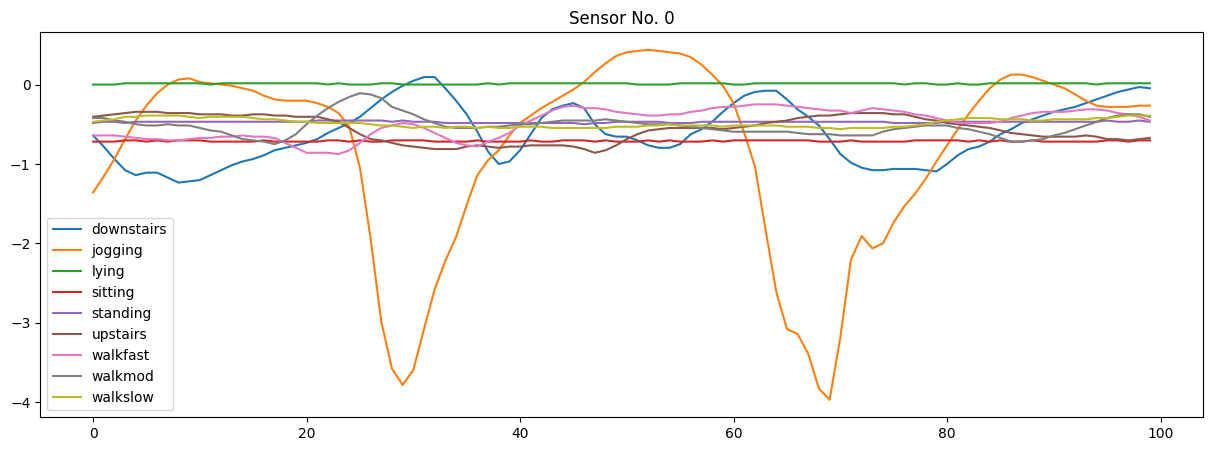

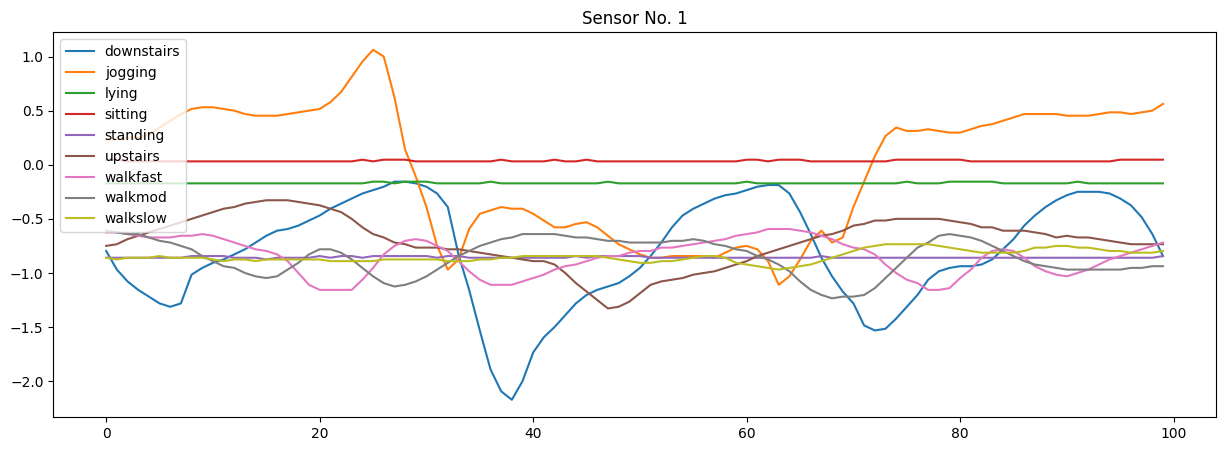

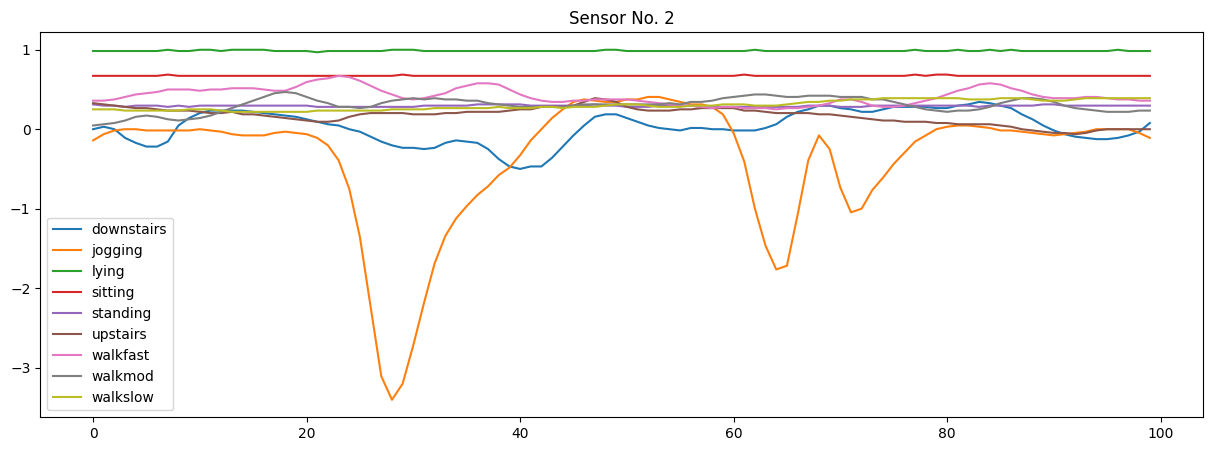

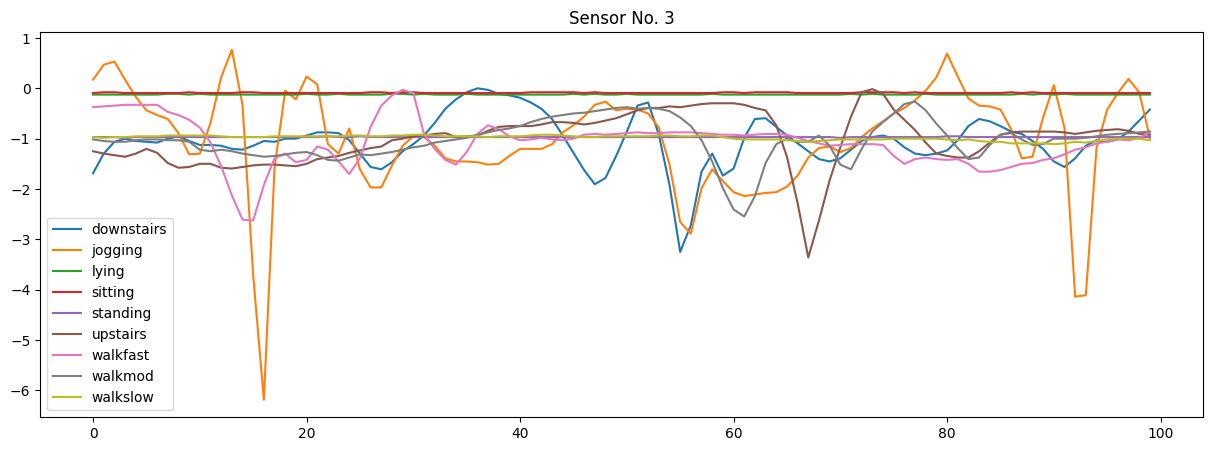

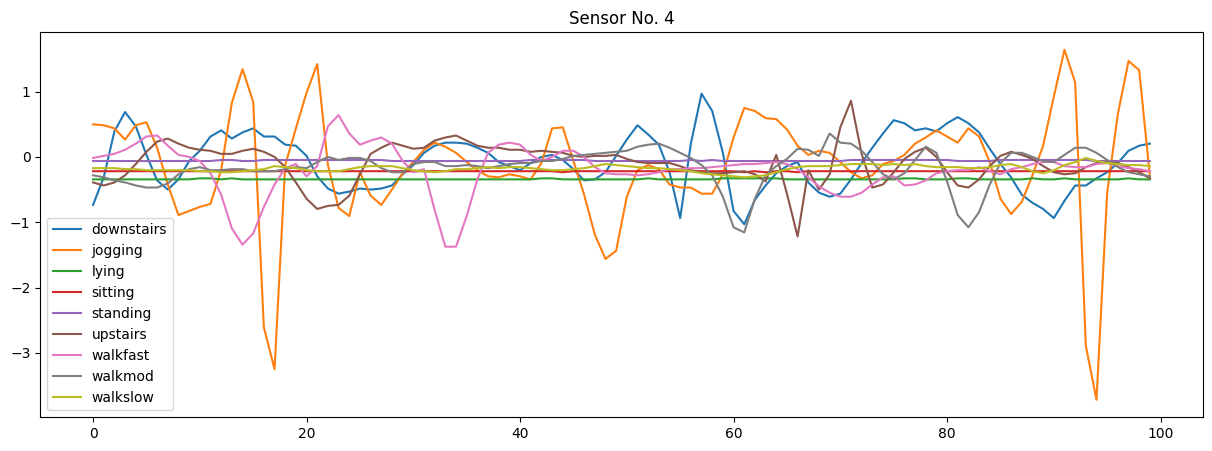

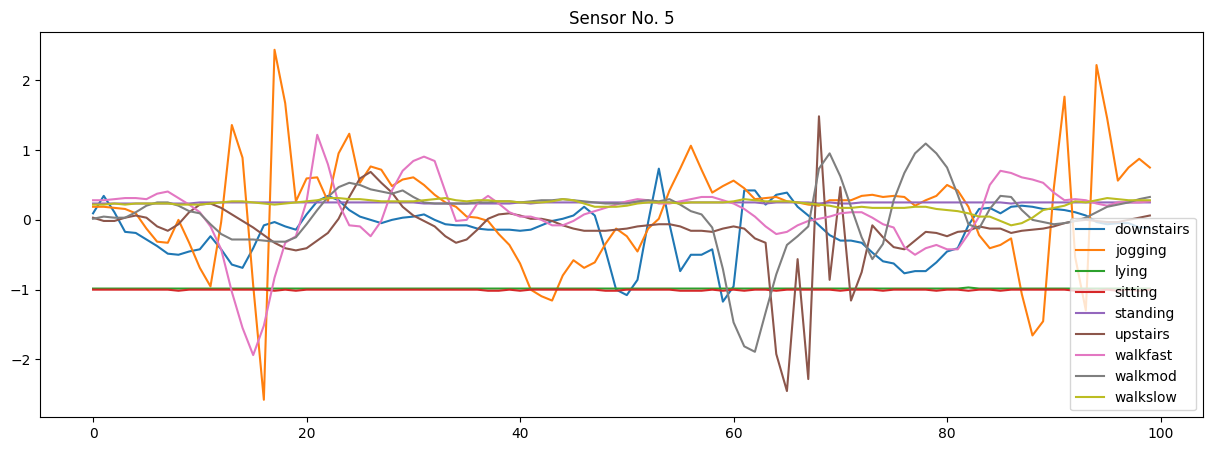

In [7]:
df_5000 = df.copy()
plot_example(df_5000)

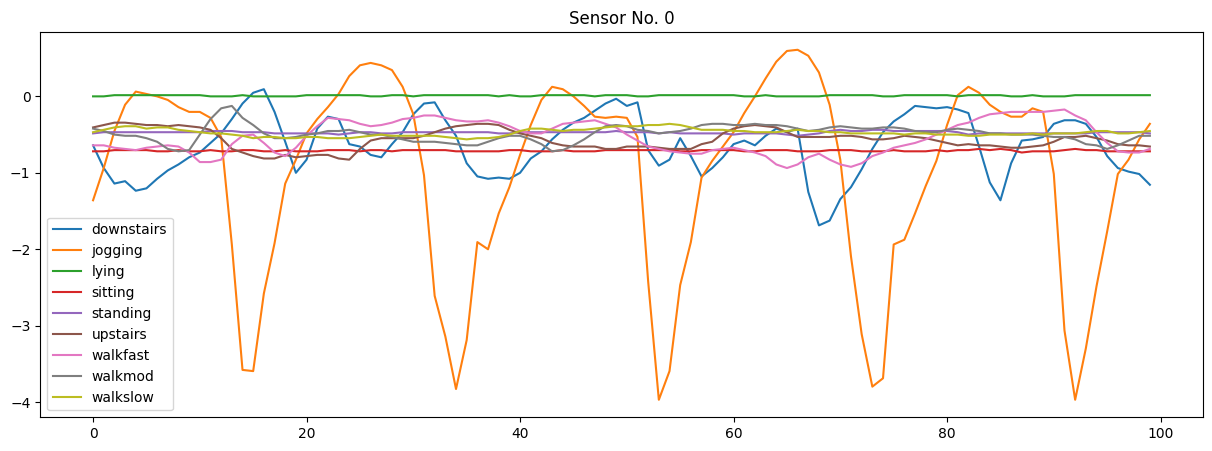

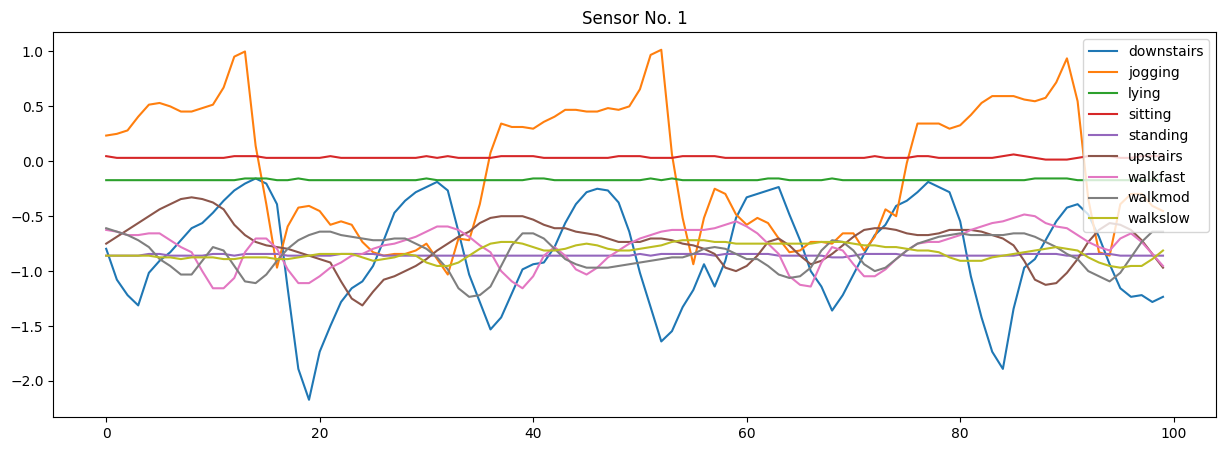

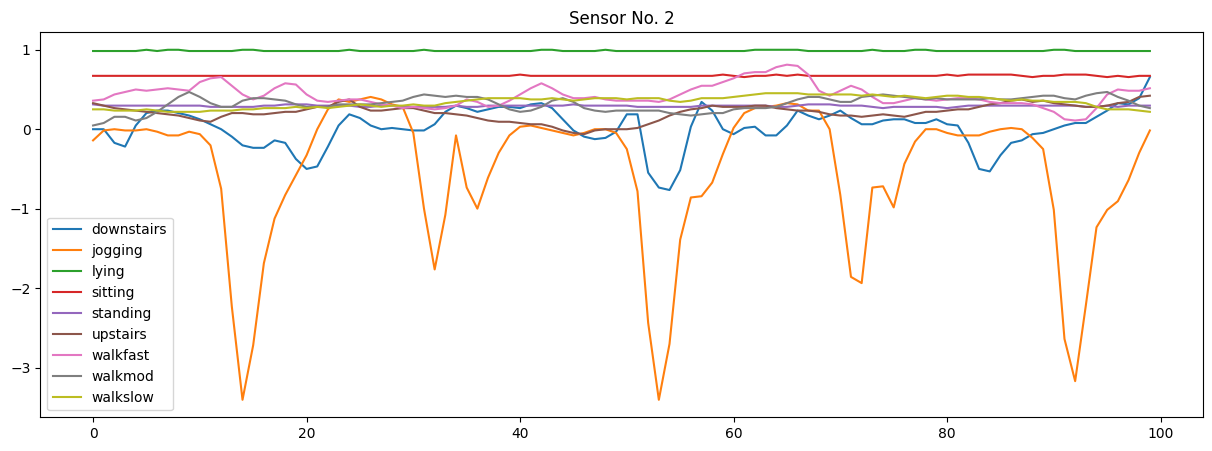

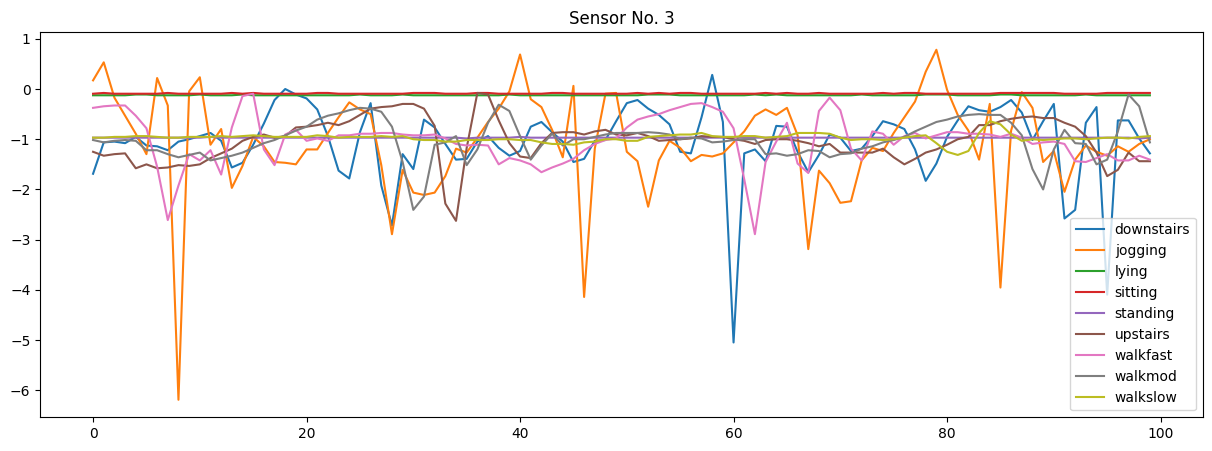

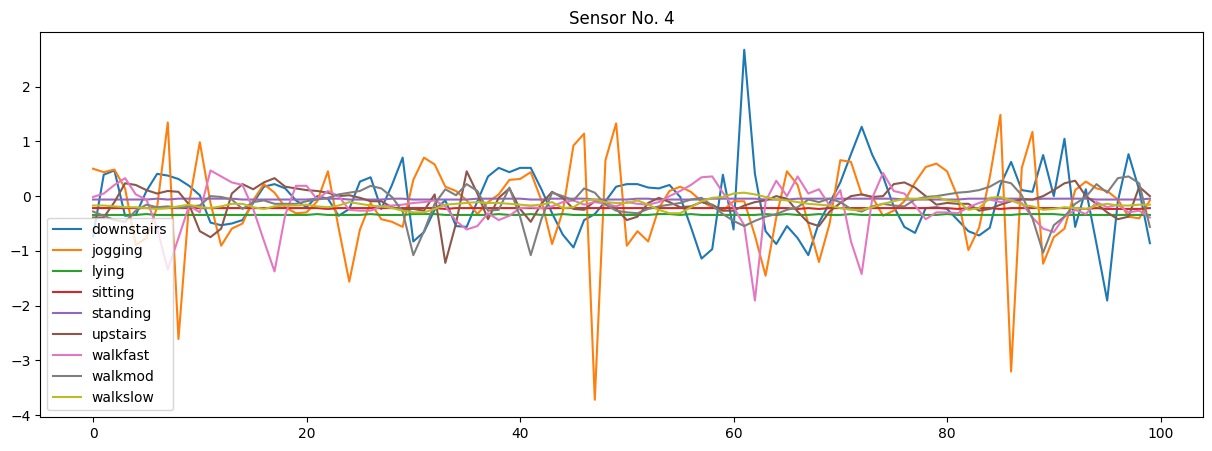

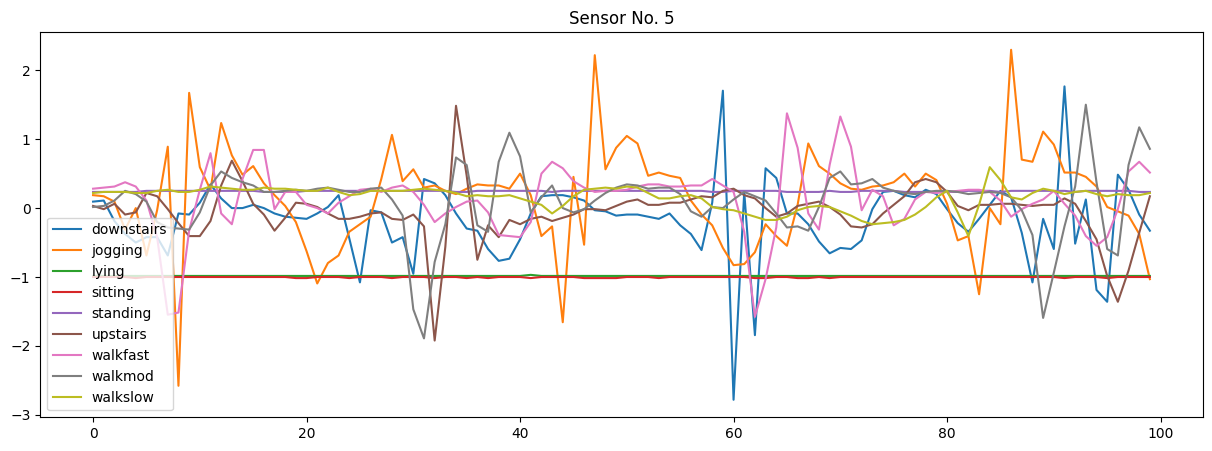

In [8]:
df_2500 = df_5000[:, :, [2 * i for i in range(2500)]]
plot_example(df_2500)

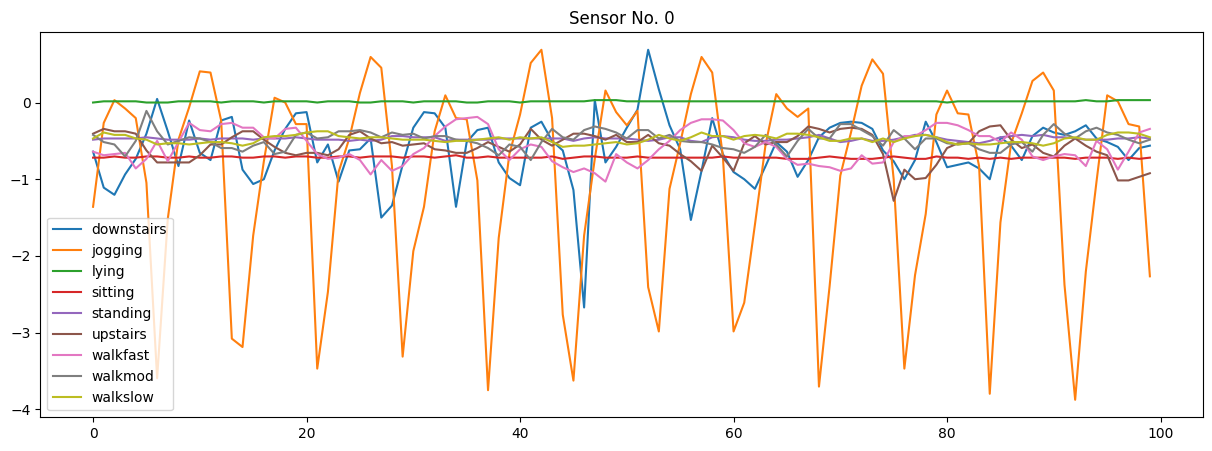

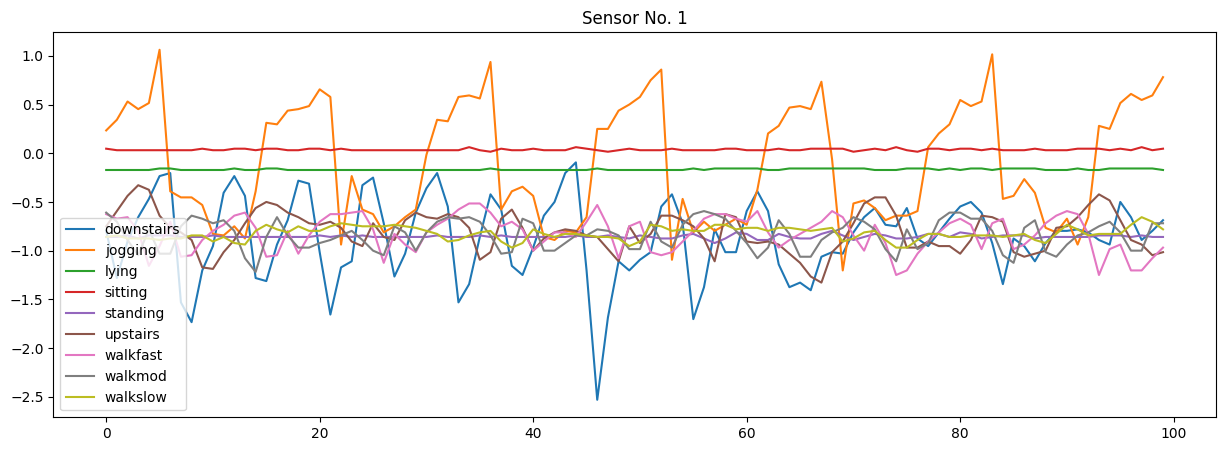

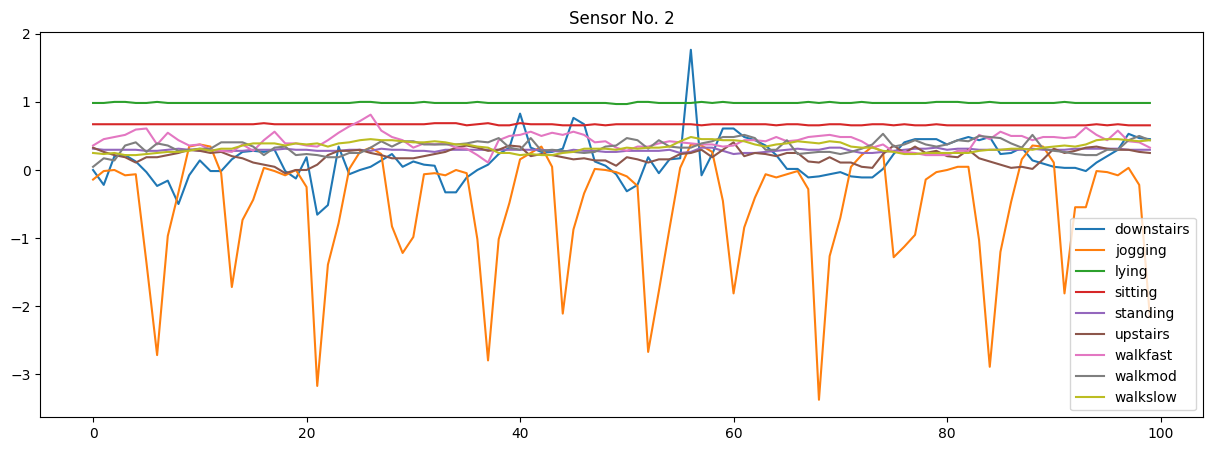

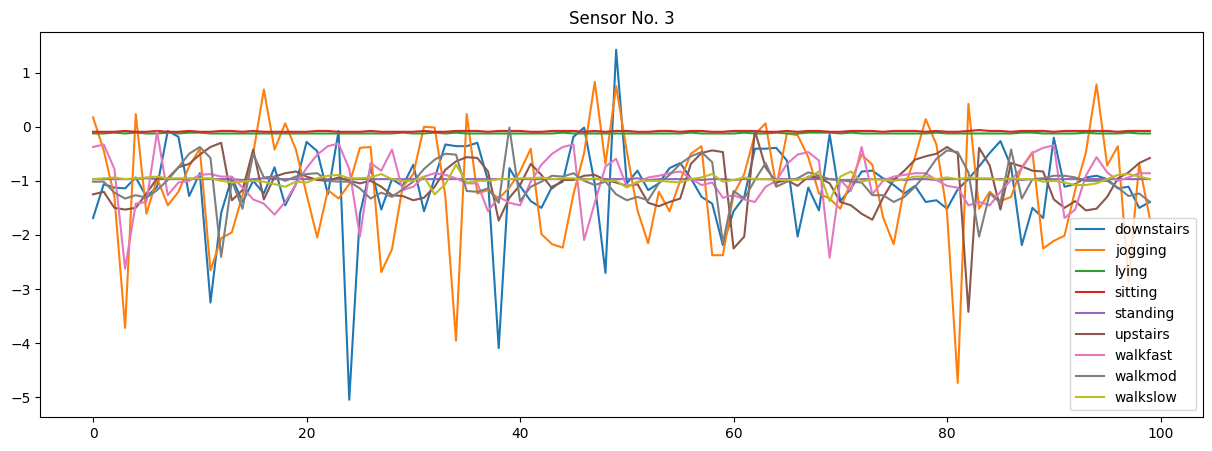

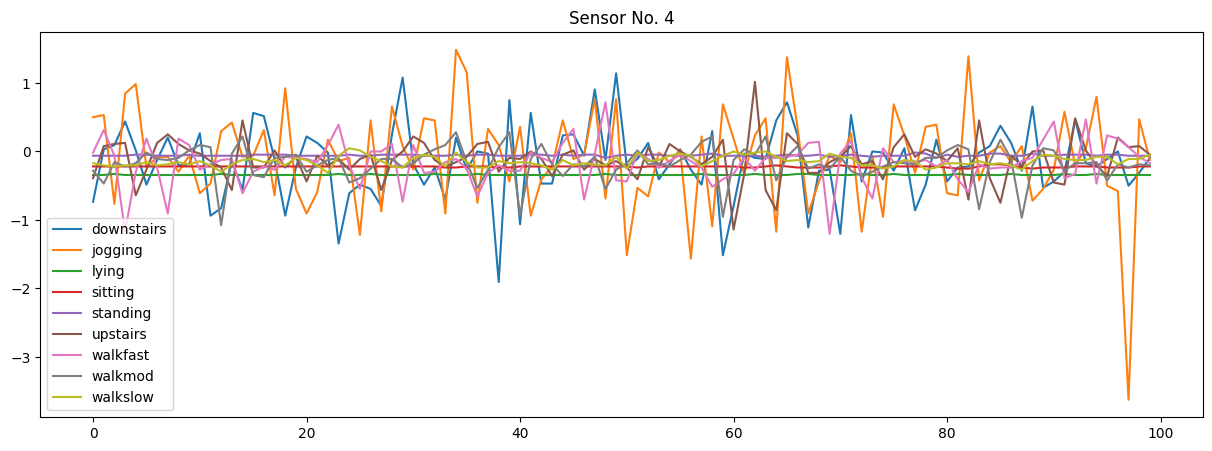

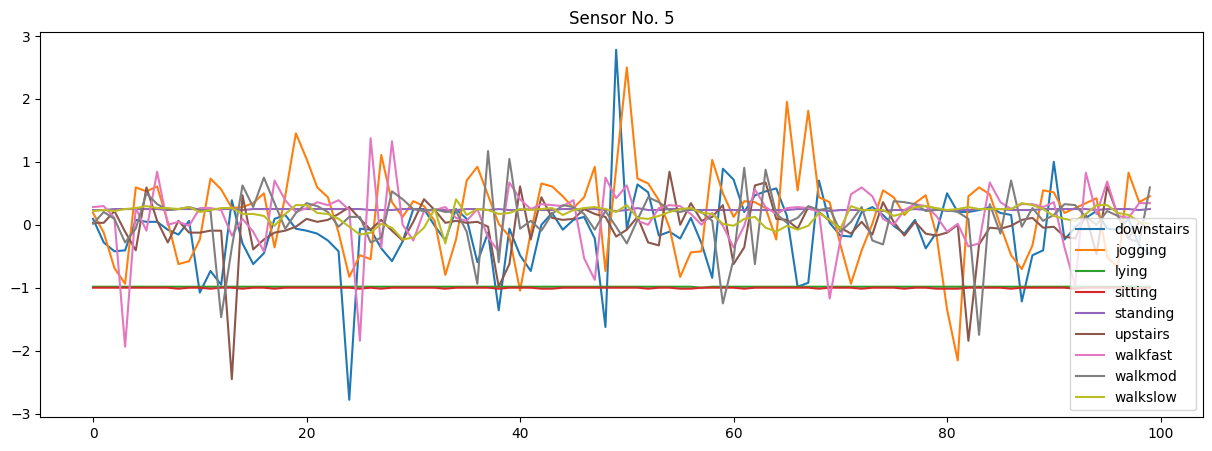

In [9]:
df_1000 = df_5000[:, :, [5 * i for i in range(1000)]]
plot_example(df_1000)

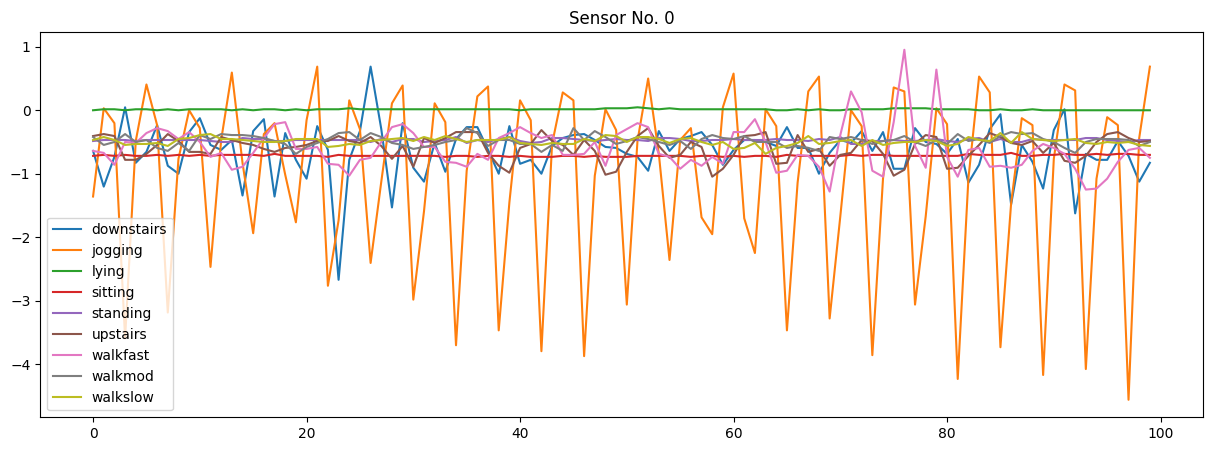

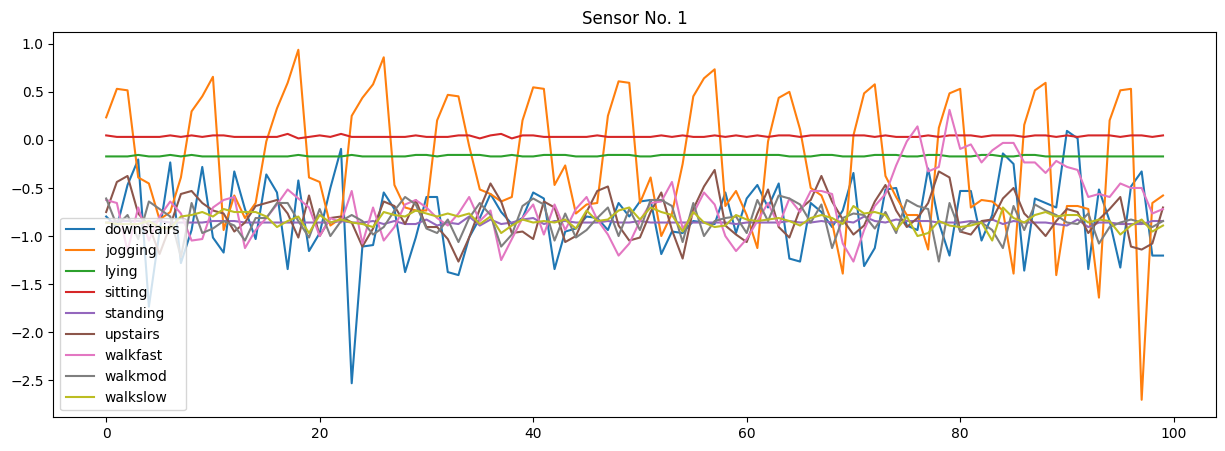

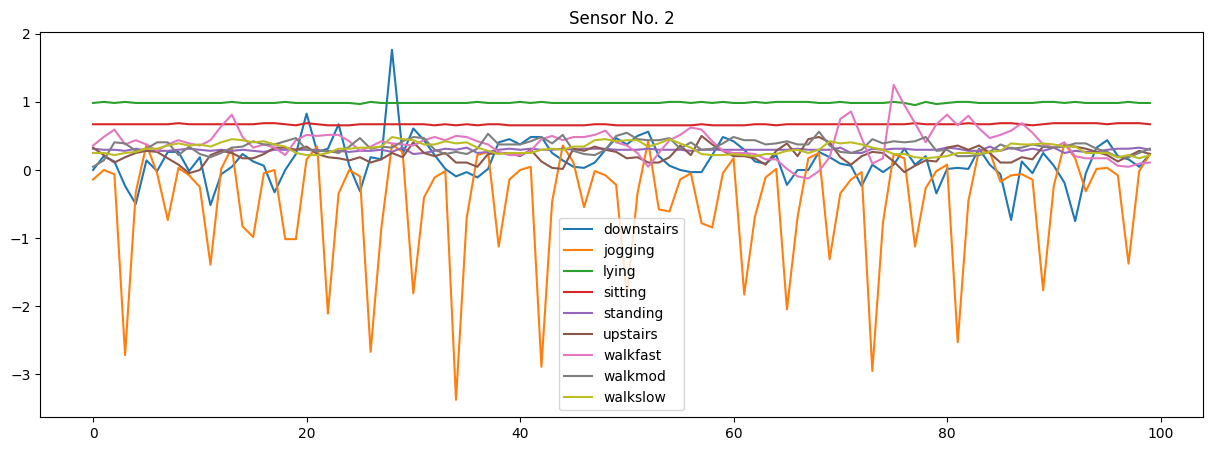

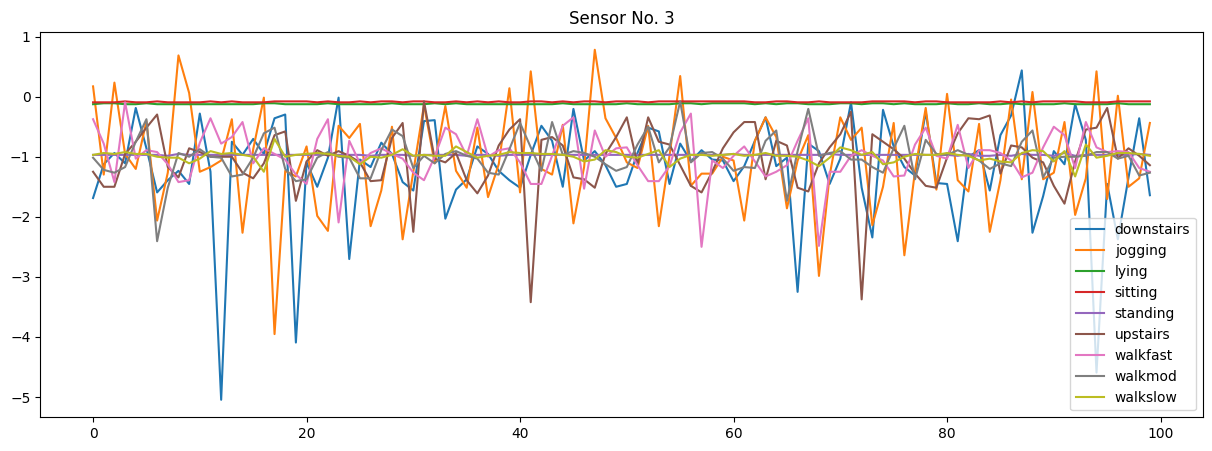

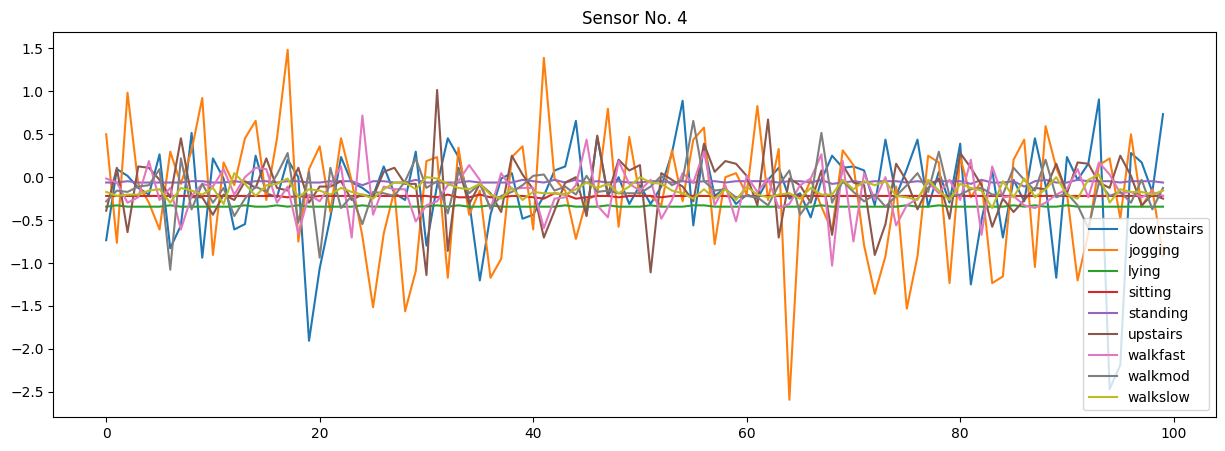

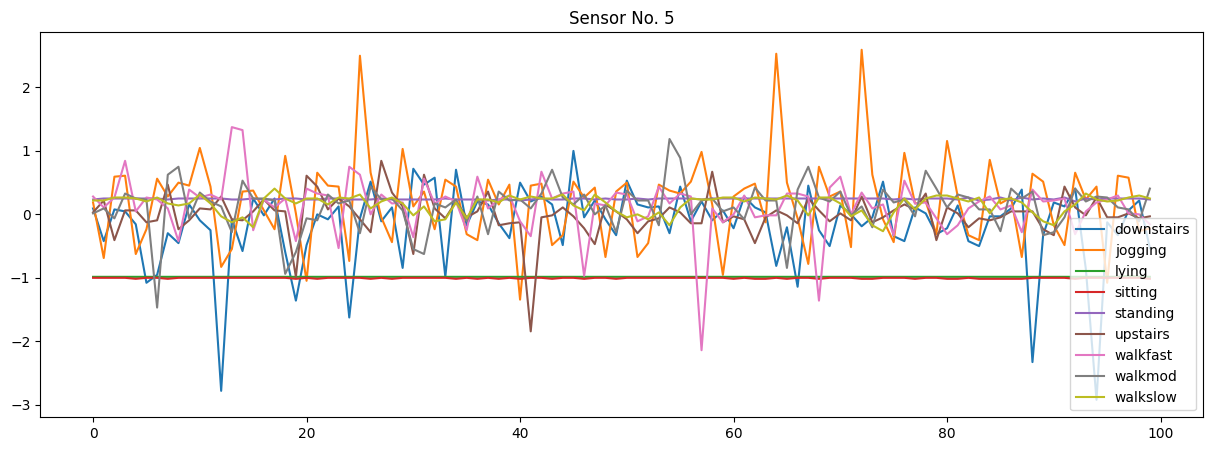

In [10]:
df_500 = df_5000[:, :, [10 * i for i in range(500)]]
plot_example(df_500)

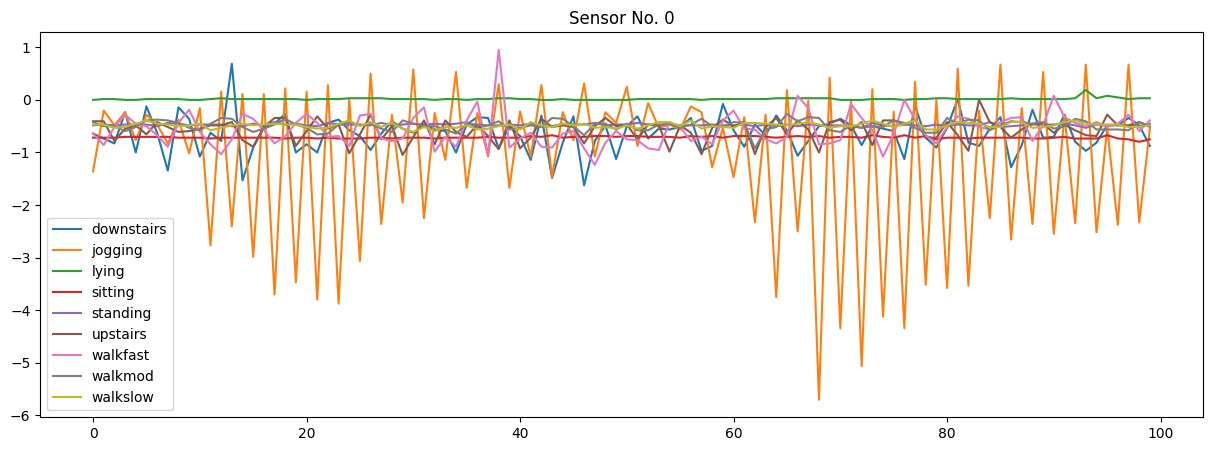

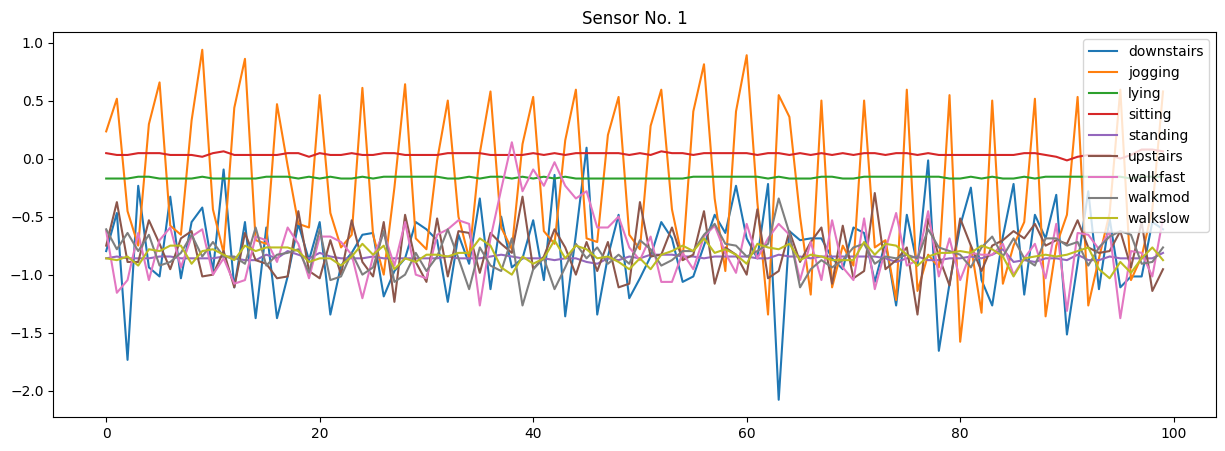

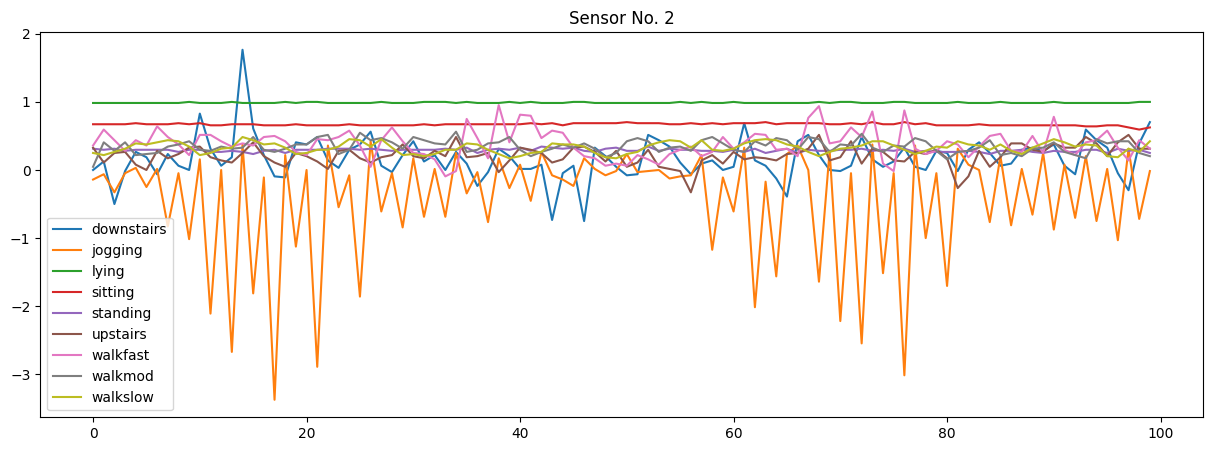

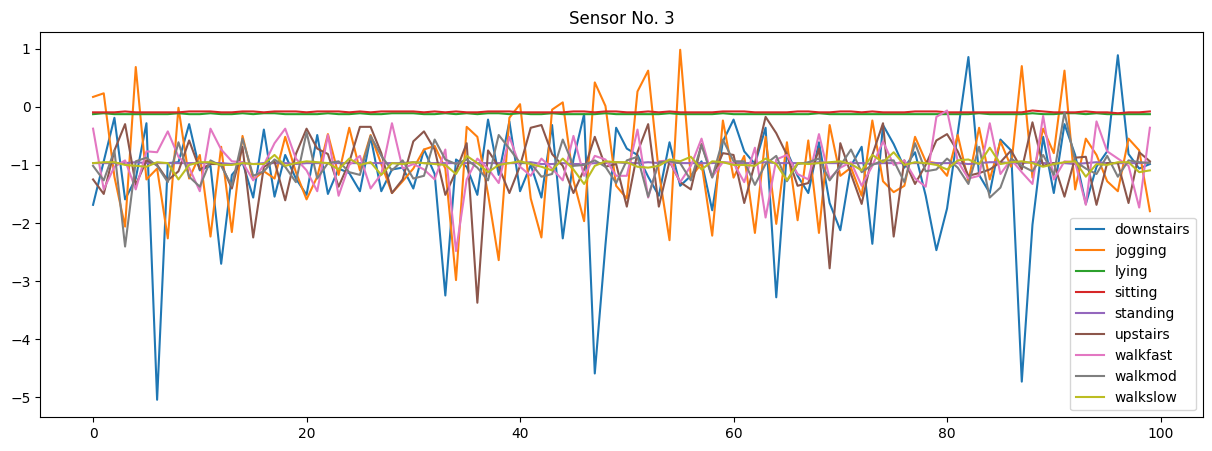

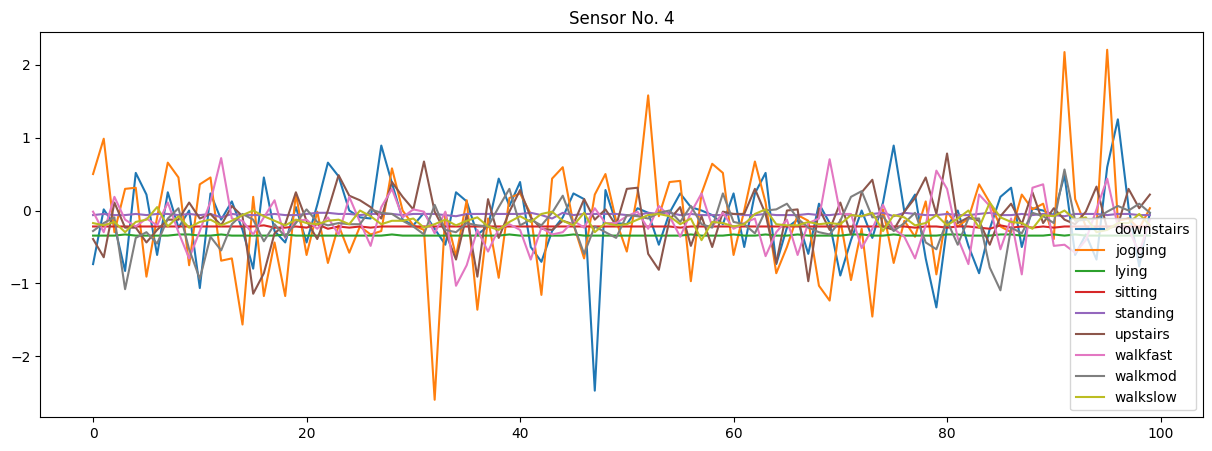

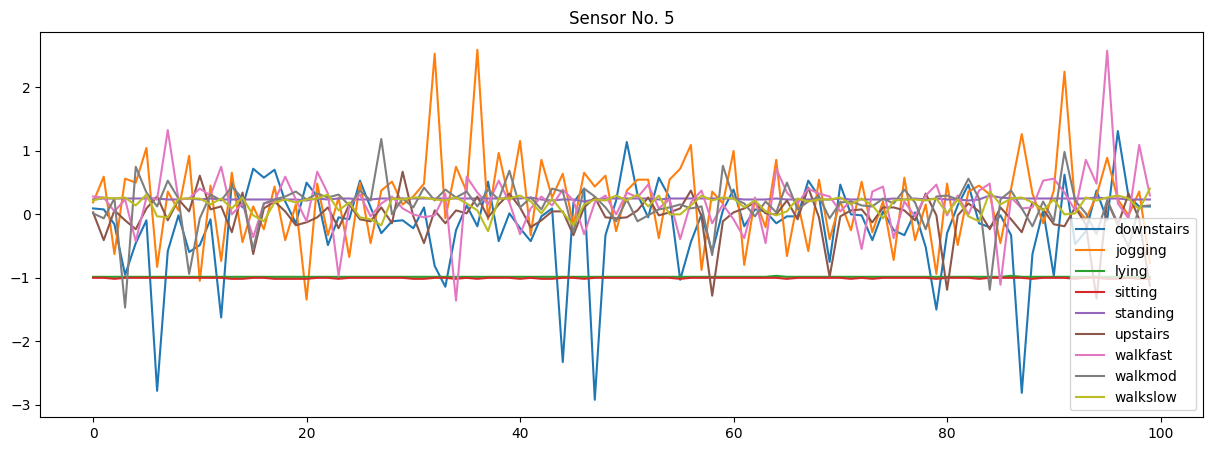

In [11]:
df_250 = df_5000[:, :, [20 * i for i in range(250)]]
plot_example(df_250)

In [86]:
def frame_reshape_offset(scale):
    df_train = []
    df_test = []

    dy_train = [act_class[:243]] * scale
    dy_test = [act_class[243:]] * scale

    for offset in range(scale):
        df_train.append(df_5000[:243, :, [scale * i + offset for i in range(int(5000 / scale))]].copy())
        df_test.append(df_5000[243:, :, [scale * i + offset for i in range(int(5000 / scale))]].copy())

    df_train_out = np.concatenate(df_train, axis=0)
    df_test_out = np.concatenate(df_test, axis=0)

    dy_train_out = np.concatenate(dy_train, axis=0)
    dy_test_out = np.concatenate(dy_test, axis=0)

    print(df_train_out.shape, df_test_out.shape, dy_train_out.shape, dy_test_out.shape)
    return df_train_out, df_test_out, dy_train_out, dy_test_out

In [32]:
testing_sets = [frame_reshape_offset(1), frame_reshape_offset(2), frame_reshape_offset(3), frame_reshape_offset(4), 
                frame_reshape_offset(5), frame_reshape_offset(10), frame_reshape_offset(20)]

(243, 6, 5000) (54, 6, 5000) (243,) (54,)
(486, 6, 2500) (108, 6, 2500) (486,) (108,)
(729, 6, 1666) (162, 6, 1666) (729,) (162,)
(972, 6, 1250) (216, 6, 1250) (972,) (216,)
(1215, 6, 1000) (270, 6, 1000) (1215,) (270,)
(2430, 6, 500) (540, 6, 500) (2430,) (540,)
(4860, 6, 250) (1080, 6, 250) (4860,) (1080,)


In [30]:
# for x_train, x_test, y_train, y_test in [(x_train_5000, x_test_5000, y_train_5000, y_test_5000),
#                                          (x_train_2500, x_test_2500, y_train_2500, y_test_2500),
#                                          (x_train_1000, x_test_1000, y_train_1000, y_test_1000),
#                                          (x_train_500, x_test_500, y_train_500, y_test_500),
#                                          (x_train_250, x_test_250, y_train_250, y_test_250)]:
#     le = LabelEncoder()
#     le.fit(np.concatenate((y_train, y_test)))
# 
#     y_train = le.transform(y_train)
#     y_test = le.transform(y_test)
# 
#     WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=[i for i in range(5, 50, 2)],
#                                     chi2_threshold=20, sparse=False)
#     WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')
# 
#     clf = make_pipeline(WEASEL_transformer, WEASEL_classifier)
#     clf.fit(x_train, y_train)
#     clf_score = clf.score(x_test, y_test)
#     print(x_train.shape[2], len(WEASEL_transformer.vocabulary_), clf_score)

5000 212024 0.8148148148148148
2500 295215 0.8518518518518519
1000 364167 0.8296296296296296
500 271831 0.8166666666666667
250 225030 0.8083333333333333


In [68]:
def get_lengths(max_length, window_length = 4):
    if max_length >= 1000:    
        return [i for i in range(window_length + 1, 999, 8)]
    elif max_length == 500:
        return [i for i in range(window_length + 1, 499, 4)]
    elif max_length == 250:
        return [i for i in range(window_length + 1, 249, 2)]
    else:
        raise ValueError('Length not verified.')

In [56]:
for chi in [2]:
    for x_train, x_test, y_train, y_test in testing_sets:
        try:
            le = LabelEncoder()
            le.fit(np.concatenate((y_train, y_test)))
        
            y_train = le.transform(y_train)
            y_test = le.transform(y_test)
        
            WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=get_lengths(x_train.shape[2]),
                                            chi2_threshold=chi, sparse=False)
            WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')
        
            clf = make_pipeline(WEASEL_transformer, WEASEL_classifier)
            clf.fit(x_train, y_train)
            clf_score = clf.score(x_test, y_test)
            
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'Vocabulary length: {len(WEASEL_transformer.vocabulary_):8d}, '
                  f'Accuracy: {100 * clf_score:6.3f}%')
        
        except ValueError:
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'Vocabulary length: --------, '
                  f'Accuracy: -------')

Sample length: 5000, Chi2:   2, Vocabulary length:  3328175, Accuracy: 85.185%
Sample length: 2500, Chi2:   2, Vocabulary length:  2808728, Accuracy: 84.259%
Sample length: 1666, Chi2:   2, Vocabulary length:  2499680, Accuracy: 85.185%
Sample length: 1250, Chi2:   2, Vocabulary length:  2216271, Accuracy: 84.722%
Sample length: 1000, Chi2:   2, Vocabulary length:  2017335, Accuracy: 84.444%


MemoryError: Unable to allocate 50.1 GiB for an array with shape (2430, 2766556) and data type int64

In [57]:
for chi in [20]:
    for x_train, x_test, y_train, y_test in testing_sets:
        try:
            le = LabelEncoder()
            le.fit(np.concatenate((y_train, y_test)))
        
            y_train = le.transform(y_train)
            y_test = le.transform(y_test)
        
            WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=get_lengths(x_train.shape[2]),
                                            chi2_threshold=chi, sparse=False)
            WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')
        
            clf = make_pipeline(WEASEL_transformer, WEASEL_classifier)
            clf.fit(x_train, y_train)
            clf_score = clf.score(x_test, y_test)
            
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'Vocabulary length: {len(WEASEL_transformer.vocabulary_):8d}, '
                  f'Accuracy: {100 * clf_score:6.3f}%')
        
        except ValueError:
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'Vocabulary length: --------, '
                  f'Accuracy: -------')

Sample length: 5000, Chi2:  20, Vocabulary length:   166172, Accuracy: 85.185%
Sample length: 2500, Chi2:  20, Vocabulary length:   198837, Accuracy: 85.185%
Sample length: 1666, Chi2:  20, Vocabulary length:   313488, Accuracy: 85.802%
Sample length: 1250, Chi2:  20, Vocabulary length:   304899, Accuracy: 83.796%
Sample length: 1000, Chi2:  20, Vocabulary length:   281966, Accuracy: 83.704%
Sample length:  500, Chi2:  20, Vocabulary length:   329958, Accuracy: 80.000%


MemoryError: Unable to allocate 14.4 GiB for an array with shape (4860, 396906) and data type int64

In [58]:
for chi in [25, 30, 40, 50, 60, 75, 95, 120, 150]:
    for x_train, x_test, y_train, y_test in testing_sets:
        try:
            le = LabelEncoder()
            le.fit(np.concatenate((y_train, y_test)))
        
            y_train = le.transform(y_train)
            y_test = le.transform(y_test)
        
            WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=get_lengths(x_train.shape[2]),
                                            chi2_threshold=chi, sparse=False)
            WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')
        
            clf = make_pipeline(WEASEL_transformer, WEASEL_classifier)
            clf.fit(x_train, y_train)
            clf_score = clf.score(x_test, y_test)
            
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'Vocabulary length: {len(WEASEL_transformer.vocabulary_):8d}, '
                  f'Accuracy: {100 * clf_score:6.3f}%')
        
        except ValueError:
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'Vocabulary length: --------, '
                  f'Accuracy: -------')
            
        except MemoryError as e:
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'{e}')

Sample length: 5000, Chi2:  25, Vocabulary length:   112466, Accuracy: 85.185%
Sample length: 2500, Chi2:  25, Vocabulary length:   133149, Accuracy: 85.185%
Sample length: 1666, Chi2:  25, Vocabulary length:   140479, Accuracy: 85.802%
Sample length: 1250, Chi2:  25, Vocabulary length:   196366, Accuracy: 83.796%
Sample length: 1000, Chi2:  25, Vocabulary length:   190410, Accuracy: 83.333%
Sample length:  500, Chi2:  25, Vocabulary length:   228569, Accuracy: 80.370%
Sample length:  250, Chi2:  25, Vocabulary length:   268092, Accuracy: 80.370%
Sample length: 5000, Chi2:  30, Vocabulary length:    85997, Accuracy: 85.185%
Sample length: 2500, Chi2:  30, Vocabulary length:    99323, Accuracy: 85.185%
Sample length: 1666, Chi2:  30, Vocabulary length:   105045, Accuracy: 85.802%
Sample length: 1250, Chi2:  30, Vocabulary length:   147654, Accuracy: 83.796%
Sample length: 1000, Chi2:  30, Vocabulary length:   149216, Accuracy: 83.333%
Sample length:  500, Chi2:  30, Vocabulary length:  

In [72]:
for chi in [20]:
    for x_train, x_test, y_train, y_test in testing_sets:
        try:
            le = LabelEncoder()
            le.fit(np.concatenate((y_train, y_test)))
        
            y_train = le.transform(y_train)
            y_test = le.transform(y_test)
        
            WEASEL_transformer = WEASELMUSE(word_size=5, n_bins=3, window_sizes=get_lengths(x_train.shape[2], 5),
                                            chi2_threshold=chi, sparse=False)
            WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')
        
            train_data = WEASEL_transformer.fit_transform(x_train, y_train)
            WEASEL_classifier.fit(train_data, y_train)
            test_data = WEASEL_transformer.transform(x_test)
            
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'Vocabulary length: {len(WEASEL_transformer.vocabulary_):8d}, '
                  f'Accuracy: {100 * WEASEL_classifier.score(test_data, y_test):6.3f}%')
        
        except ValueError:
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'Vocabulary length: --------, '
                  f'Accuracy: -------')
            
        except MemoryError as e:
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'{e}')

Sample length: 5000, Chi2:  20, Vocabulary length:   161652, Accuracy: 85.185%
Sample length: 2500, Chi2:  20, Vocabulary length:   201408, Accuracy: 85.185%
Sample length: 1666, Chi2:  20, Vocabulary length:   365024, Accuracy: 85.185%
Sample length: 1250, Chi2:  20, Vocabulary length:   360537, Accuracy: 83.796%
Sample length: 1000, Chi2:  20, Vocabulary length:   343594, Accuracy: 84.444%
Sample length:  500, Chi2:  20, Vocabulary length:   408840, Accuracy: 82.037%
Sample length:  250, Chi2:  20, Vocabulary length: --------, Accuracy: -------


In [63]:
for chi in [20]:
    for x_train, x_test, y_train, y_test in testing_sets:
        try:
            le = LabelEncoder()
            le.fit(np.concatenate((y_train, y_test)))
        
            y_train = le.transform(y_train)
            y_test = le.transform(y_test)
        
            WEASEL_transformer = WEASELMUSE(word_size=6, n_bins=3, window_sizes=get_lengths(x_train.shape[2], 6),
                                            chi2_threshold=chi, sparse=False)
            WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')
        
            train_data = WEASEL_transformer.fit_transform(x_train, y_train)
            WEASEL_classifier.fit(train_data, y_train)
            test_data = WEASEL_transformer.transform(x_test)
            
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'Vocabulary length: {len(WEASEL_transformer.vocabulary_):8d}, '
                  f'Accuracy: {100 * WEASEL_classifier.score(test_data, y_test):6.3f}%')
        
        except ValueError:
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'Vocabulary length: --------, '
                  f'Accuracy: -------')
            
        except MemoryError as e:
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'{e}')

Sample length: 5000, Chi2:  20, Vocabulary length:   154341, Accuracy: 79.630%
Sample length: 2500, Chi2:  20, Vocabulary length:   192851, Accuracy: 82.407%
Sample length: 1666, Chi2:  20, Vocabulary length:   371378, Accuracy: 84.568%
Sample length: 1250, Chi2:  20, Vocabulary length:   376271, Accuracy: 81.481%
Sample length: 1000, Chi2:  20, Vocabulary length:   358532, Accuracy: 79.630%
Sample length:  500, Chi2:  20, Vocabulary length:   416904, Accuracy: 80.185%
Sample length:  250, Chi2:  20, Vocabulary length:   497820, Accuracy: 78.889%


In [73]:
testing_sets = [frame_reshape_offset(1), frame_reshape_offset(3), frame_reshape_offset(4), 
                frame_reshape_offset(5), frame_reshape_offset(7), frame_reshape_offset(9)]

(243, 6, 5000) (54, 6, 5000) (243,) (54,)
(729, 6, 1666) (162, 6, 1666) (729,) (162,)
(972, 6, 1250) (216, 6, 1250) (972,) (216,)
(1215, 6, 1000) (270, 6, 1000) (1215,) (270,)
(1701, 6, 714) (378, 6, 714) (1701,) (378,)
(2187, 6, 555) (486, 6, 555) (2187,) (486,)


In [74]:
for chi in [20]:
    for x_train, x_test, y_train, y_test in testing_sets:
        try:
            le = LabelEncoder()
            le.fit(np.concatenate((y_train, y_test)))
        
            y_train = le.transform(y_train)
            y_test = le.transform(y_test)
        
            WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=get_lengths(x_train.shape[2]),
                                            chi2_threshold=chi, sparse=False)
            WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')
        
            train_data = WEASEL_transformer.fit_transform(x_train, y_train)
            WEASEL_classifier.fit(train_data, y_train)
            test_data = WEASEL_transformer.transform(x_test)
            
            scale = int(len(y_test) / 54)
            y_grouped = [[y_test[i] for i in range(len(y_test)) if i % 54 == j] for j in range(54)]
            
            for index in range(54):
                # may cause uneven incorrect label distribution, not an issue in this project
                y_grouped[index] = max(set(y_grouped[index]), key=y_grouped[index].count)
            
            test_grouped = y_grouped.copy()
            for _ in range(scale - 1):
                test_grouped.extend(y_grouped.copy())
            
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'Vocabulary length: {len(WEASEL_transformer.vocabulary_):8d}, '
                  f'Accuracy: {100 * WEASEL_classifier.score(test_data, test_grouped):6.3f}%')
        
        except ValueError:
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'Vocabulary length: --------, '
                  f'Accuracy: -------')
            
        except MemoryError as e:
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'{e}')

Sample length: 5000, Chi2:  20, Vocabulary length:   166172, Accuracy: 85.185%
Sample length: 1666, Chi2:  20, Vocabulary length:   313488, Accuracy: 85.802%
Sample length: 1250, Chi2:  20, Vocabulary length:   304899, Accuracy: 83.796%
Sample length: 1000, Chi2:  20, Vocabulary length:   281966, Accuracy: 83.704%
Sample length:  714, Chi2:  20, Vocabulary length: --------, Accuracy: -------
Sample length:  555, Chi2:  20, Vocabulary length: --------, Accuracy: -------


In [75]:
testing_sets = [frame_reshape_offset(1), frame_reshape_offset(3)]

(243, 6, 5000) (54, 6, 5000) (243,) (54,)
(729, 6, 1666) (162, 6, 1666) (729,) (162,)


In [76]:
def get_lengths(max_length, window_length = 4):
    if max_length >= 500:
        return [i for i in range(window_length + 1, 499, 4)]
    elif max_length == 250:
        return [i for i in range(window_length + 1, 249, 2)]
    else:
        raise ValueError('Length not verified.')

In [77]:
for chi in [2, 3, 5, 8, 13, 20]:
    for x_train, x_test, y_train, y_test in testing_sets:
        try:
            le = LabelEncoder()
            le.fit(np.concatenate((y_train, y_test)))
        
            y_train = le.transform(y_train)
            y_test = le.transform(y_test)
        
            WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=get_lengths(x_train.shape[2]),
                                            chi2_threshold=chi, sparse=False)
            WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')
        
            train_data = WEASEL_transformer.fit_transform(x_train, y_train)
            WEASEL_classifier.fit(train_data, y_train)
            test_data = WEASEL_transformer.transform(x_test)
            
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'Vocabulary length: {len(WEASEL_transformer.vocabulary_):8d}, '
                  f'Accuracy: {100 * WEASEL_classifier.score(test_data, y_test):6.3f}%')
        
        except ValueError:
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'Vocabulary length: --------, '
                  f'Accuracy: -------')
            
        except MemoryError as e:
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'{e}')

Sample length: 5000, Chi2:   2, Vocabulary length:  4846542, Accuracy: 87.037%
Sample length: 1666, Chi2:   2, Vocabulary length:  4241466, Accuracy: 85.185%
Sample length: 5000, Chi2:   3, Vocabulary length:  4841315, Accuracy: 87.037%
Sample length: 1666, Chi2:   3, Vocabulary length:  4239135, Accuracy: 85.185%
Sample length: 5000, Chi2:   5, Vocabulary length:  4787816, Accuracy: 87.037%
Sample length: 1666, Chi2:   5, Unable to allocate 22.9 GiB for an array with shape (729, 4212462) and data type int64
Sample length: 5000, Chi2:   8, Vocabulary length:  3571776, Accuracy: 87.037%
Sample length: 1666, Chi2:   8, Vocabulary length:  3433608, Accuracy: 85.185%
Sample length: 5000, Chi2:  13, Vocabulary length:   711734, Accuracy: 87.037%
Sample length: 1666, Chi2:  13, Vocabulary length:  1138830, Accuracy: 84.568%
Sample length: 5000, Chi2:  20, Vocabulary length:   295097, Accuracy: 87.037%
Sample length: 1666, Chi2:  20, Vocabulary length:   504722, Accuracy: 85.185%


In [79]:
def frame_reshape_division(parts):
    df_train = []
    df_test = []

    part_size = int(5000 / parts)
    dy_train = [act_class[:243]] * parts
    dy_test = [act_class[243:]] * parts

    for part in range(parts):
        df_train.append(df_5000[:243, :, (part * part_size):((part + 1) * part_size)].copy())
        df_test.append(df_5000[243:, :, (part * part_size):((part + 1) * part_size)].copy())

    df_train_out = np.concatenate(df_train, axis=0)
    df_test_out = np.concatenate(df_test, axis=0)

    dy_train_out = np.concatenate(dy_train, axis=0)
    dy_test_out = np.concatenate(dy_test, axis=0)

    print(df_train_out.shape, df_test_out.shape, dy_train_out.shape, dy_test_out.shape)
    return df_train_out, df_test_out, dy_train_out, dy_test_out

In [80]:
testing_sets = [frame_reshape_division(1), frame_reshape_division(2), frame_reshape_division(3), frame_reshape_division(4), 
                frame_reshape_division(5), frame_reshape_division(10), frame_reshape_division(20)]

(243, 6, 5000) (54, 6, 5000) (243,) (54,)
(486, 6, 2500) (108, 6, 2500) (486,) (108,)
(729, 6, 1666) (162, 6, 1666) (729,) (162,)
(972, 6, 1250) (216, 6, 1250) (972,) (216,)
(1215, 6, 1000) (270, 6, 1000) (1215,) (270,)
(2430, 6, 500) (540, 6, 500) (2430,) (540,)
(4860, 6, 250) (1080, 6, 250) (4860,) (1080,)


In [82]:
for chi in [2]:
    for x_train, x_test, y_train, y_test in testing_sets[1:3]:
        try:
            le = LabelEncoder()
            le.fit(np.concatenate((y_train, y_test)))
        
            y_train = le.transform(y_train)
            y_test = le.transform(y_test)
        
            WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=get_lengths(x_train.shape[2]),
                                            chi2_threshold=chi, sparse=False)
            WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')
        
            train_data = WEASEL_transformer.fit_transform(x_train, y_train)
            WEASEL_classifier.fit(train_data, y_train)
            test_data = WEASEL_transformer.transform(x_test)
            
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'Vocabulary length: {len(WEASEL_transformer.vocabulary_):8d}, '
                  f'Accuracy: {100 * WEASEL_classifier.score(test_data, y_test):6.3f}%')
        
        except ValueError:
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'Vocabulary length: --------, '
                  f'Accuracy: -------')
            
        except MemoryError as e:
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'{e}')

Sample length: 2500, Chi2:   2, Vocabulary length:  4644760, Accuracy: 86.111%
Sample length: 1666, Chi2:   2, Vocabulary length:  4422586, Accuracy: 83.951%


In [84]:
for chi in [2, 10, 20]:
    for x_train, x_test, y_train, y_test in testing_sets:
        try:
            le = LabelEncoder()
            le.fit(np.concatenate((y_train, y_test)))
        
            y_train = le.transform(y_train)
            y_test = le.transform(y_test)
        
            WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, window_sizes=get_lengths(x_train.shape[2]),
                                            chi2_threshold=chi, sparse=False)
            WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')
        
            train_data = WEASEL_transformer.fit_transform(x_train, y_train)
            WEASEL_classifier.fit(train_data, y_train)
            test_data = WEASEL_transformer.transform(x_test)
            
            scale = int(len(y_test) / 54)
            y_grouped = [[y_test[i] for i in range(len(y_test)) if i % 54 == j] for j in range(54)]
            
            for index in range(54):
                # may cause uneven incorrect label distribution, not an issue in this project
                y_grouped[index] = max(set(y_grouped[index]), key=y_grouped[index].count)
            
            test_grouped = y_grouped.copy()
            for _ in range(scale - 1):
                test_grouped.extend(y_grouped.copy())
            
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'Vocabulary length: {len(WEASEL_transformer.vocabulary_):8d}, '
                  f'Accuracy: {100 * WEASEL_classifier.score(test_data, test_grouped):6.3f}%')
        
        except ValueError:
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'Vocabulary length: --------, '
                  f'Accuracy: -------')
            
        except MemoryError as e:
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'{e}')

Sample length: 5000, Chi2:   2, Vocabulary length:  4846542, Accuracy: 87.037%
Sample length: 2500, Chi2:   2, Vocabulary length:  4644760, Accuracy: 86.111%
Sample length: 1666, Chi2:   2, Vocabulary length:  4422586, Accuracy: 83.951%
Sample length: 1250, Chi2:   2, Vocabulary length:  4168493, Accuracy: 83.333%
Sample length: 1000, Chi2:   2, Vocabulary length:  4007481, Accuracy: 84.444%
Sample length:  500, Chi2:   2, Unable to allocate 49.1 GiB for an array with shape (2430, 2712949) and data type int64
Sample length:  250, Chi2:   2, Unable to allocate 121. GiB for an array with shape (4860, 3339025) and data type int64
Sample length: 5000, Chi2:  10, Vocabulary length:  1041463, Accuracy: 87.037%
Sample length: 2500, Chi2:  10, Vocabulary length:   981621, Accuracy: 85.185%
Sample length: 1666, Chi2:  10, Vocabulary length:   962821, Accuracy: 84.568%
Sample length: 1250, Chi2:  10, Vocabulary length:   924464, Accuracy: 84.259%
Sample length: 1000, Chi2:  10, Vocabulary length

In [97]:
# TODO different window lengths
testing_sets = [frame_reshape_offset(1), frame_reshape_offset(3)]

(243, 6, 5000) (54, 6, 5000) (243,) (54,)
(729, 6, 1666) (162, 6, 1666) (729,) (162,)


In [98]:
for chi in [2, 20]:
    for x_train, x_test, y_train, y_test in testing_sets:
        try:
            le = LabelEncoder()
            le.fit(np.concatenate((y_train, y_test)))
        
            y_train = le.transform(y_train)
            y_test = le.transform(y_test)
        
            WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, 
                                            window_sizes=[i for i in range(5, 500, 1)],
                                            chi2_threshold=chi, sparse=False)
            WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')
        
            train_data = WEASEL_transformer.fit_transform(x_train, y_train)
            WEASEL_classifier.fit(train_data, y_train)
            test_data = WEASEL_transformer.transform(x_test)
            
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'Vocabulary length: {len(WEASEL_transformer.vocabulary_):8d}, '
                  f'Accuracy: {100 * WEASEL_classifier.score(test_data, y_test):6.3f}%')
        
        except ValueError:
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'Vocabulary length: --------, '
                  f'Accuracy: -------')
            
        except MemoryError as e:
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'{e}')

Sample length: 5000, Chi2:   2, Vocabulary length: --------, Accuracy: -------
Sample length: 1666, Chi2:   2, Unable to allocate 91.6 GiB for an array with shape (729, 16856952) and data type int64
Sample length: 5000, Chi2:  20, Vocabulary length: --------, Accuracy: -------
Sample length: 1666, Chi2:  20, Vocabulary length:  1975615, Accuracy: 86.420%


In [88]:
for chi in [2, 20]:
    for x_train, x_test, y_train, y_test in testing_sets:
        try:
            le = LabelEncoder()
            le.fit(np.concatenate((y_train, y_test)))
        
            y_train = le.transform(y_train)
            y_test = le.transform(y_test)
        
            WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, 
                                            window_sizes=[i for i in range(5, x_train.shape[2], 1)],
                                            chi2_threshold=chi, sparse=False)
            WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')
        
            train_data = WEASEL_transformer.fit_transform(x_train, y_train)
            WEASEL_classifier.fit(train_data, y_train)
            test_data = WEASEL_transformer.transform(x_test)
            
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'Vocabulary length: {len(WEASEL_transformer.vocabulary_):8d}, '
                  f'Accuracy: {100 * WEASEL_classifier.score(test_data, y_test):6.3f}%')
        
        except ValueError:
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'Vocabulary length: --------, '
                  f'Accuracy: -------')
            
        except MemoryError as e:
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'{e}')

Sample length: 5000, Chi2:   2, Vocabulary length: --------, Accuracy: -------
Sample length: 1666, Chi2:   2, Unable to allocate 110. GiB for an array with shape (729, 20323720) and data type int64
Sample length: 5000, Chi2:  20, Vocabulary length: --------, Accuracy: -------
Sample length: 1666, Chi2:  20, Vocabulary length:  2580652, Accuracy: 87.037%


In [89]:
# TODO grouping activities

def class_mapper_three(label):
    if label == 'lying' or label == 'sitting' or label == 'standing':
        return 0
    if label == 'downstairs' or label == 'upstairs' or label == 'walkslow' or label == 'walkmod':
        return 1
    else:  # jogging, walkfast
        return 2
    
def class_mapper_two(label):
    if label == 'lying' or label == 'sitting' or label == 'standing':
        return 0
    else:  # downstairs, jogging, upstairs, walkfast, walkmod, walkslow
        return 1

In [92]:
print(testing_sets[0][2][:9])

result = map(class_mapper_three, testing_sets[0][2])
print(list(result)[:9])

result = map(class_mapper_two, testing_sets[0][2])
print(list(result)[:9])

['downstairs' 'jogging' 'lying' 'sitting' 'standing' 'upstairs' 'walkfast'
 'walkmod' 'walkslow' 'downstairs']
[1, 2, 0, 0, 0, 1, 2, 1, 1, 1]
[1, 1, 0, 0, 0, 1, 1, 1, 1, 1]


In [100]:
testing_sets = [frame_reshape_offset(1), frame_reshape_offset(2), frame_reshape_offset(3), frame_reshape_offset(4)]

(243, 6, 5000) (54, 6, 5000) (243,) (54,)
(486, 6, 2500) (108, 6, 2500) (486,) (108,)
(729, 6, 1666) (162, 6, 1666) (729,) (162,)
(972, 6, 1250) (216, 6, 1250) (972,) (216,)


In [101]:
for chi in [2, 20]:
    for x_train, x_test, y_train, y_test in testing_sets:
        try:       
            y_train = list(map(class_mapper_three, y_train))
            y_test = list(map(class_mapper_three, y_test))
        
            WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, 
                                            window_sizes=[i for i in range(5, 500, 1)],
                                            chi2_threshold=chi, sparse=False)
            WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')
        
            train_data = WEASEL_transformer.fit_transform(x_train, y_train)
            WEASEL_classifier.fit(train_data, y_train)
            test_data = WEASEL_transformer.transform(x_test)
            
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'Vocabulary length: {len(WEASEL_transformer.vocabulary_):8d}, '
                  f'Accuracy: {100 * WEASEL_classifier.score(test_data, y_test):6.3f}%')
        
        except ValueError:
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'Vocabulary length: --------, '
                  f'Accuracy: -------')
            
        except MemoryError as e:
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'{e}')

Sample length: 5000, Chi2:   2, Vocabulary length: --------, Accuracy: -------
Sample length: 2500, Chi2:   2, Vocabulary length: 11697147, Accuracy: 96.296%
Sample length: 1666, Chi2:   2, Unable to allocate 42.9 GiB for an array with shape (729, 7904952) and data type int64
Sample length: 1250, Chi2:   2, Vocabulary length: --------, Accuracy: -------
Sample length: 5000, Chi2:  20, Vocabulary length: --------, Accuracy: -------
Sample length: 2500, Chi2:  20, Vocabulary length:   359268, Accuracy: 95.370%
Sample length: 1666, Chi2:  20, Vocabulary length:   319212, Accuracy: 95.062%
Sample length: 1250, Chi2:  20, Vocabulary length: --------, Accuracy: -------


In [102]:
for chi in [2, 20]:
    for x_train, x_test, y_train, y_test in testing_sets:
        try:       
            y_train = list(map(class_mapper_two, y_train))
            y_test = list(map(class_mapper_two, y_test))
        
            WEASEL_transformer = WEASELMUSE(word_size=4, n_bins=3, 
                                            window_sizes=[i for i in range(5, 500, 1)],
                                            chi2_threshold=chi, sparse=False)
            WEASEL_classifier = LogisticRegression(solver='liblinear', multi_class='ovr')
        
            train_data = WEASEL_transformer.fit_transform(x_train, y_train)
            WEASEL_classifier.fit(train_data, y_train)
            test_data = WEASEL_transformer.transform(x_test)
            
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'Vocabulary length: {len(WEASEL_transformer.vocabulary_):8d}, '
                  f'Accuracy: {100 * WEASEL_classifier.score(test_data, y_test):6.3f}%')
        
        except ValueError:
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'Vocabulary length: --------, '
                  f'Accuracy: -------')
            
        except MemoryError as e:
            print(f'Sample length: {x_train.shape[2]:4d}, '
                  f'Chi2: {chi:3d}, '
                  f'{e}')

Sample length: 5000, Chi2:   2, Vocabulary length: --------, Accuracy: -------
Sample length: 2500, Chi2:   2, Vocabulary length:  6554684, Accuracy: 100.000%
Sample length: 1666, Chi2:   2, Unable to allocate 32.9 GiB for an array with shape (729, 6060959) and data type int64
Sample length: 1250, Chi2:   2, Vocabulary length: --------, Accuracy: -------
Sample length: 5000, Chi2:  20, Vocabulary length: --------, Accuracy: -------
Sample length: 2500, Chi2:  20, Vocabulary length:   187710, Accuracy: 100.000%
Sample length: 1666, Chi2:  20, Vocabulary length:   174390, Accuracy: 100.000%
Sample length: 1250, Chi2:  20, Vocabulary length: --------, Accuracy: -------
